# Прогнозирование температуры стали при десульфировании

## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.
Модель будет использоваться для моделирования различных сценариев технологического процесса. Конечные пользователи - технологи заказчика на производстве.

Дополнительные условия:
* Целевая метрика MAE <= 6. Метрика легко интерпретируемая и согласована с заказчиком.
* В разработке модели должны быть использованы данные только о партиях (столбец `key`), информация о которых есть во всех предоставленных таблицах.
* В результатах измерений температуры каждому ключу (`key`, номер партии) соответствует несколько наблюдений, соответствующие разным итерациям обработки. Задача - предсказать конечную температуру, то есть самое последнее наблюдение по ключу.
* В данных об электродах, а также в замерах температуры присутствуют отрицательные и аномально низкие значения реактивной мощности. По информации от заказчика - это выбросы, использование которых при построении модели не рекомендуется.
* По информации от заказчика наличие только одного замера температуры - потерянные данные, так как десульфирование проводится всегда. Таким образом, наличие хотя бы двух замеров температуры является обязательным условием для партии для использования при обучении модели
* Также по информации от заказчика минимальная температура при десульфировании 1500 градусов. Температура ниже свидетельствует либо о нарушении техпроцесса, либо сбое в измерениях, в обоих случаях такие данные рекомендуется не использовать при обучении модели

## Импорт данных

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler

# models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

## Константы

In [128]:
RANDOM_STATE = 80822

## EDA

### Данные об электродах

In [129]:
try:
    data_arc = pd.read_csv('final_steel/data_arc.csv')
except: 
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [130]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Явные пропуски отсутствуют. Типы колонок по дате/времени использованы object вместо datetime

In [131]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

In [132]:
data_arc.describe(datetime_is_numeric=True)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-02 16:15:28.218203904,2019-07-02 16:18:19.889150208,0.670441,0.452592
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.030002,-715.504924
25%,806.000000,2019-06-02 07:01:09.249999872,2019-06-02 07:04:21,0.395297,0.290991
50%,1617.000000,2019-06-30 09:57:14.500000,2019-06-30 10:01:01,0.555517,0.415962
75%,2429.000000,2019-08-03 13:04:47.750000128,2019-08-03 13:09:14,0.857034,0.637371
max,3241.000000,2019-09-01 04:34:47,2019-09-01 04:36:08,3.731596,2.676388
std,934.571502,NaN,NaN,0.408159,5.878702


In [133]:
data_arc['key'].nunique()

3214

* Номер партии варьируется от 1 до 3241. При этом уникальных значений 3214.
* В реактивной мощности присутствуют отрицательные значения
* В датасете есть данные за 4 месяца: с 3 мая по 1 сентября 2019

In [134]:
data_arc.key.value_counts().sort_values(ascending=False).describe()

count    3214.000000
mean        4.628500
std         1.608647
min         1.000000
25%         4.000000
50%         4.000000
75%         6.000000
max        16.000000
Name: key, dtype: float64

Максимальное число итераций нагрева 16, минимальное 1. В среднем нагревают 4.6 раза.

<AxesSubplot:>

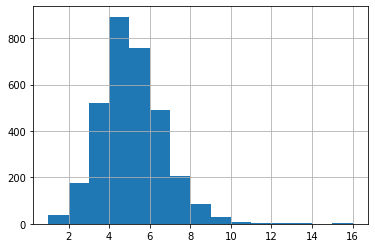

In [135]:
data_arc.key.value_counts().hist(bins=15)

{'whiskers': [<matplotlib.lines.Line2D at 0x20c8e724308>,
 'caps': [<matplotlib.lines.Line2D at 0x20c8e724c88>,
 'boxes': [<matplotlib.lines.Line2D at 0x20c8e4ddc48>],
 'medians': [<matplotlib.lines.Line2D at 0x20c8e72d5c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x20c8e72da88>],
 'means': []}

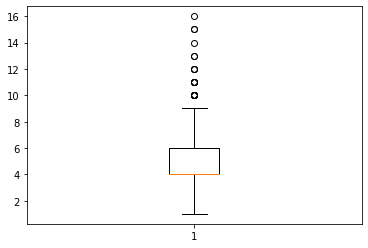

In [136]:
plt.boxplot(data_arc.key.value_counts())

Распределение количества итераций нагрева нормальное. При этом нагревы 10 раз и более являются редкими.

In [137]:
data_arc.duplicated().sum()

0

Явных дубликатов не обнаружено.

<AxesSubplot:>

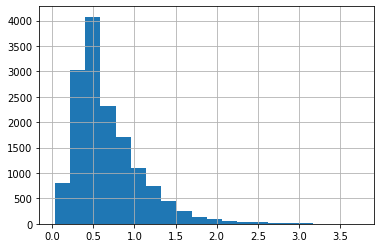

In [138]:
data_arc['Активная мощность'].hist(bins=20)

{'whiskers': [<matplotlib.lines.Line2D at 0x20c8e854a88>,
 'caps': [<matplotlib.lines.Line2D at 0x20c8e854a08>,
 'boxes': [<matplotlib.lines.Line2D at 0x20c8e854488>],
 'medians': [<matplotlib.lines.Line2D at 0x20c8e85ba88>],
 'fliers': [<matplotlib.lines.Line2D at 0x20c8e85bf08>],
 'means': []}

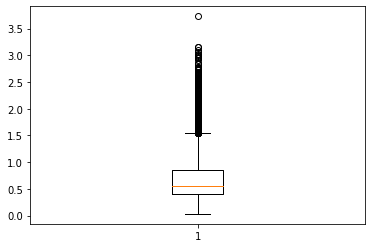

In [139]:
plt.boxplot(data_arc['Активная мощность'])

Распределение активной мощности нормальное, скошенное вправо. Отрицательных и нулевых значений не наблюдается. Выбросами являются значения выше 1.5

<AxesSubplot:>

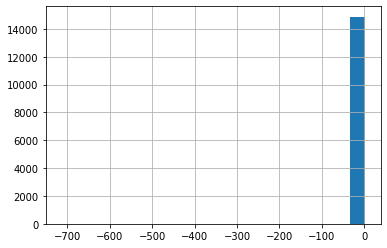

In [140]:
data_arc['Реактивная мощность'].hist(bins=20)

В столбце Реактивная мощность присутствуют сильные выбросы

<AxesSubplot:>

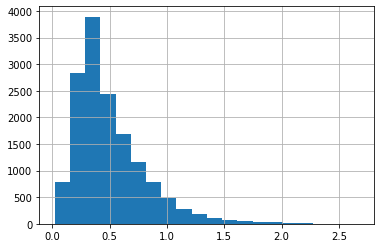

In [141]:
data_arc.loc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'].hist(bins=20)

{'whiskers': [<matplotlib.lines.Line2D at 0x20c8ea3bdc8>,
 'caps': [<matplotlib.lines.Line2D at 0x20c8ea3f5c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x20c8ea3b608>],
 'medians': [<matplotlib.lines.Line2D at 0x20c8ea456c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x20c8ea45cc8>],
 'means': []}

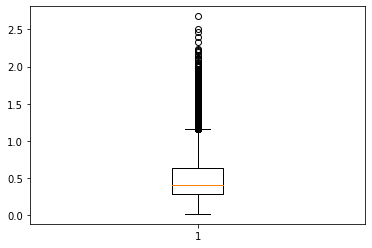

In [142]:
plt.boxplot(data_arc.loc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'])

За исключением выбросов распределение по реактивной мощности нормальное, скошенное вправо.

В качестве дополнительных признаков предлагается рассчитать
* суммарную затраченную электроэнергию (кВт*ч)
* среднюю мощность
* суммарное время нагрева
* среднее отношение активной мощности к реактивной.
* количество итераций нагрева

### Данные о подаче сыпучих материалов (объём)

In [143]:
try:
    data_bulk = pd.read_csv('final_steel/data_bulk.csv')
except:
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [144]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Виды примесей разнятся по частоте использования, существуют достаточно редкие, например Bulk 8 использовался только один раз. Соответственно в датасете много пропусков

In [145]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


array([[<AxesSubplot:title={'center':'Bulk 1'}>,
        <AxesSubplot:title={'center':'Bulk 2'}>,
        <AxesSubplot:title={'center':'Bulk 3'}>,
        <AxesSubplot:title={'center':'Bulk 4'}>],
       [<AxesSubplot:title={'center':'Bulk 5'}>,
        <AxesSubplot:title={'center':'Bulk 6'}>,
        <AxesSubplot:title={'center':'Bulk 7'}>,
        <AxesSubplot:title={'center':'Bulk 8'}>],
       [<AxesSubplot:title={'center':'Bulk 9'}>,
        <AxesSubplot:title={'center':'Bulk 10'}>,
        <AxesSubplot:title={'center':'Bulk 11'}>,
        <AxesSubplot:title={'center':'Bulk 12'}>],
       [<AxesSubplot:title={'center':'Bulk 13'}>,
        <AxesSubplot:title={'center':'Bulk 14'}>,
        <AxesSubplot:title={'center':'Bulk 15'}>, <AxesSubplot:>]],
      dtype=object)

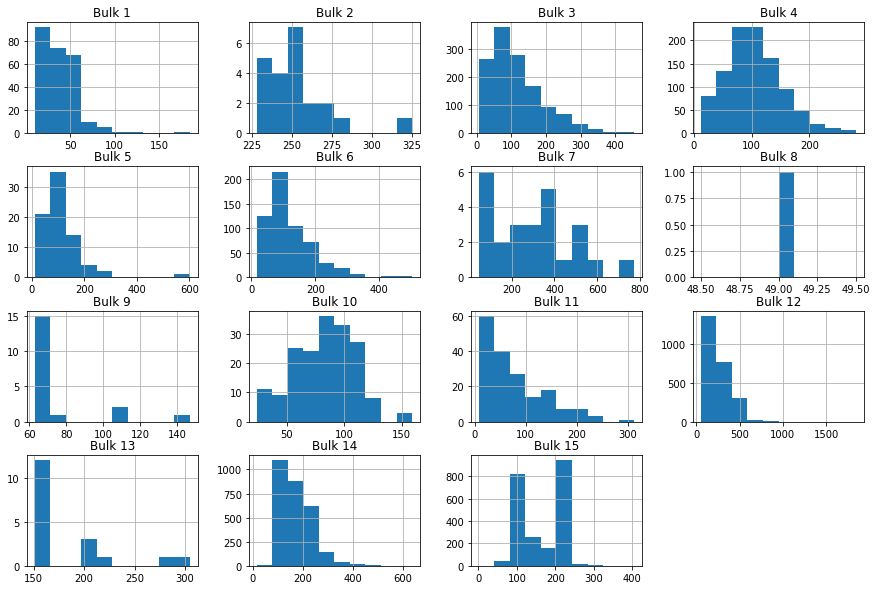

In [146]:
data_bulk.drop('key', axis=1).hist(figsize=(15,10))

In [147]:
data_bulk['key'].nunique()

3129

Количество уникальных партий соответствует количеству строк, однако меньше уникальных значений датасета об электродах.

In [148]:
data_bulk.drop('key', axis=1).corr()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
Bulk 1,1.000000,-0.073762,0.016731,-0.040465,-0.368980,0.141745,-0.086223,NaN,NaN,-0.278055,0.461895,0.370501,1.000000,0.409188,-0.119006
Bulk 2,-0.073762,1.000000,NaN,0.393882,0.070350,NaN,-0.010043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 3,0.016731,NaN,1.000000,-0.260918,0.144410,0.253080,NaN,NaN,0.072850,-0.244532,0.137997,0.011648,-0.582598,0.026257,-0.023689
Bulk 4,-0.040465,0.393882,-0.260918,1.000000,-0.077214,-0.333841,0.324940,NaN,0.766565,-0.516399,NaN,0.051112,-0.311659,0.022925,0.041190
Bulk 5,-0.368980,0.070350,0.144410,-0.077214,1.000000,-0.511112,0.304476,NaN,NaN,NaN,NaN,0.007650,NaN,-0.256040,-0.248216
Bulk 6,0.141745,NaN,0.253080,-0.333841,-0.511112,1.000000,NaN,NaN,NaN,NaN,-0.104251,-0.079822,0.844690,0.154429,-0.038363
Bulk 7,-0.086223,-0.010043,NaN,0.324940,0.304476,NaN,1.000000,NaN,NaN,NaN,NaN,0.538671,NaN,1.000000,NaN
Bulk 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 9,NaN,NaN,0.072850,0.766565,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.946954,NaN,-0.479974,NaN
Bulk 10,-0.278055,NaN,-0.244532,-0.516399,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,-0.026418,NaN,-0.248683,0.076409


<AxesSubplot:>

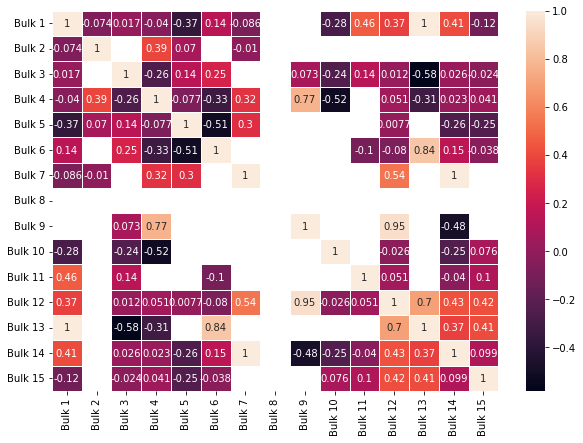

In [149]:
plt.figure(figsize = (10,7))
sns.heatmap(data_bulk.drop('key', axis=1).corr(), linewidths=.5, annot=True)


Наблюдается высокая корреляция некоторых примесей друг с другом. Высокая корреляция между признаками может повлиять на переобучение модели относительно таких признаков.

In [150]:
def get_high_corr_colnames(dataset, threshold):
    high_corr_colnames = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= threshold:
                colname = corr_matrix.columns[i]
                rowname = corr_matrix.T.columns[j]
                print(colname, '-', rowname)
                high_corr_colnames.add(colname)
    return high_corr_colnames

In [151]:
get_high_corr_colnames(data_bulk.drop('key', axis=1), 0.9)

Bulk 12 - Bulk 9
Bulk 13 - Bulk 1
Bulk 14 - Bulk 7


{'Bulk 12', 'Bulk 13', 'Bulk 14'}

Высокая корреляция наблюдается между 12 и 9, 13 и 1 а также 14 и 7 примесями. Следует оставить по одному из них с учетом частоты их использования

### Данные о подаче сыпучих материалов (время)

In [152]:
try:
    data_bulk_time = pd.read_csv('final_steel/data_bulk_time.csv')
except:
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [153]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [154]:
for column in data_bulk_time.columns[1:]:
    data_bulk_time[column] = pd.to_datetime(data_bulk_time[column])

In [155]:
data_bulk_time.describe(datetime_is_numeric=True)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
mean,1624.383509,2019-06-27 08:32:26.031746048,2019-07-09 02:04:44.545454336,2019-07-05 14:02:19.653312768,2019-06-30 17:27:38.687376896,2019-07-10 12:23:28.623376640,2019-07-03 15:57:30.003472384,2019-07-23 21:38:41.040000,2019-07-05 17:46:11,2019-06-21 00:53:43.157894912,2019-07-04 02:03:09.647727616,2019-07-11 23:35:46.310734336,2019-07-03 02:04:28.317142784,2019-06-29 02:00:06.722222336,2019-07-03 10:03:08.939059200,2019-07-03 16:07:21.480871936
min,1.000000,2019-05-03 17:50:19,2019-05-07 08:36:19,2019-05-03 20:13:36,2019-05-03 11:21:30,2019-05-07 08:36:19,2019-05-03 18:52:57,2019-05-07 11:37:42,2019-07-05 17:46:11,2019-05-14 00:04:56,2019-05-06 01:36:24,2019-05-05 16:45:05,2019-05-03 11:03:52,2019-05-05 00:39:35,2019-05-03 11:03:52,2019-05-03 11:03:52
25%,816.000000,2019-05-28 02:36:05.750000128,2019-05-26 21:24:43.249999872,2019-06-06 08:39:05.500000,2019-05-29 08:23:05.750000128,2019-06-17 19:42:11,2019-06-05 04:40:07,2019-07-17 11:25:12,2019-07-05 17:46:11,2019-05-14 02:37:23.500000,2019-05-31 15:29:27.500000,2019-06-12 19:24:37,2019-06-01 23:11:18,2019-05-27 22:41:40.750000128,2019-06-02 12:09:03.249999872,2019-06-02 18:47:20.249999872
50%,1622.000000,2019-06-23 02:31:45.500000,2019-07-23 15:06:49.500000,2019-07-01 17:13:22,2019-06-25 18:44:37.500000,2019-07-21 23:25:54,2019-07-06 03:56:28.500000,2019-07-23 15:37:44,2019-07-05 17:46:11,2019-05-14 05:15:06,2019-07-03 08:39:55.500000,2019-07-20 18:08:09,2019-06-30 09:36:04,2019-06-28 22:21:35,2019-07-01 05:46:54.500000,2019-07-01 00:46:14.500000
75%,2431.000000,2019-07-27 00:38:33.249999872,2019-08-08 10:55:53.750000128,2019-08-06 14:11:27.750000128,2019-07-30 21:37:44,2019-08-08 11:51:23,2019-08-03 09:02:40.750000128,2019-08-08 12:03:38,2019-07-05 17:46:11,2019-08-11 11:43:13,2019-07-30 19:28:59,2019-08-06 18:01:34,2019-08-04 04:41:33.249999872,2019-07-31 15:31:55.249999872,2019-08-04 17:37:32,2019-08-04 22:40:55
max,3241.000000,2019-08-30 23:01:32,2019-08-08 17:34:38,2019-08-31 23:39:11,2019-08-30 17:36:30,2019-08-28 09:01:08,2019-09-01 03:12:40,2019-08-31 07:22:25,2019-07-05 17:46:11,2019-08-11 15:09:33,2019-08-30 01:30:42,2019-08-31 16:00:49,2019-09-01 01:39:41,2019-08-26 20:31:16,2019-09-01 04:05:34,2019-09-01 04:05:34
std,933.337642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В датасете присутствуют данные о примесях начиная с 3 мая 2019 по 1 сентября 2019, что соответствует периода сбора данных о нагреве электродов.

### Данные о продувке сплава газом

In [156]:
try:
    data_gas = pd.read_csv('final_steel/data_gas.csv')
except:
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [157]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Явных пропусков нет

In [158]:
data_gas['key'].nunique()

3239

Количество уникальных значений номеров партий соответствует количеству строк, дубликатов нет. Однако оно больше количества уникальных значений из датасета об электродах

In [159]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Объем продувки газом варьируется от 0.008399б до 77.99504. В среднем используется 11

<AxesSubplot:>

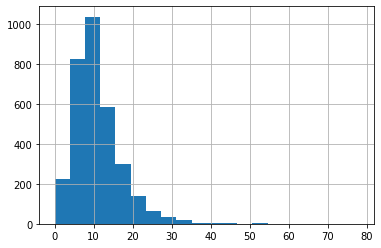

In [160]:
data_gas['Газ 1'].hist(bins=20)

{'whiskers': [<matplotlib.lines.Line2D at 0x20c902b2948>,
 'caps': [<matplotlib.lines.Line2D at 0x20c902b2fc8>,
 'boxes': [<matplotlib.lines.Line2D at 0x20c902b2348>],
 'medians': [<matplotlib.lines.Line2D at 0x20c902b9948>],
 'fliers': [<matplotlib.lines.Line2D at 0x20c902b9dc8>],
 'means': []}

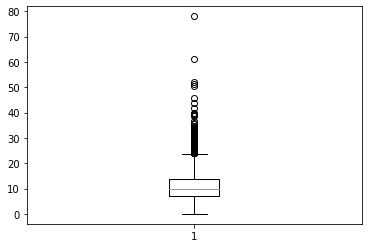

In [161]:
plt.boxplot(data_gas['Газ 1'])

Распределение о продувке газом нормальное, скошенное вправо. На boxplot наблюдаются выбросы, однако необходимо проверить количество итераций, чтобы убедиться

In [162]:
data_gas[data_gas['Газ 1'] > 50]

,key,Газ 1
116,117,50.581035
277,280,60.935689
319,322,77.995040
2107,2110,52.142373
2567,2570,51.380229


In [163]:
high_gas_keys = data_gas[data_gas['Газ 1'] > 50]['key']
data_arc.query('key in @high_gas_keys')['key'].value_counts()

322     13
280      9
2570     9
117      6
2110     5
Name: key, dtype: int64

По данным партиям действительно было сравнительно много итераций, возможно большой объем газа оправдан.

In [164]:
high_iters_keys = data_arc['key'].value_counts().sort_values(ascending=False).index[:5]
data_gas.query('key in @high_iters_keys')

,key,Газ 1
45,46,6.118441
1510,1513,38.471706
1686,1689,33.597044
2105,2108,45.638999
2564,2567,39.378164


При этом почти по всем партиям с большим количеством итераций наблюдается большой объем использованного газа

### Результаты измерения температуры

In [165]:
try:
    data_temp = pd.read_csv('final_steel/data_temp.csv')
except:
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [166]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


В датасете наблюдаются пропуски в колонке Температура

In [167]:
data_temp['key'].nunique()

3216

Количество уникальных значений номеров партий больше количества уникальных значений из датасета об электродах

In [168]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

In [169]:
data_temp.describe(datetime_is_numeric=True)

,key,Время замера,Температура
count,15907.000000,15907,13006.000000
mean,1607.880870,2019-07-02 09:55:01.000942848,1591.840920
min,1.000000,2019-05-03 11:16:18,1191.000000
25%,790.000000,2019-06-01 16:24:51.500000,1581.000000
50%,1618.000000,2019-06-30 10:31:14,1591.000000
75%,2427.000000,2019-08-03 12:07:59,1601.000000
max,3241.000000,2019-09-01 04:38:08,1705.000000
std,942.212073,NaN,21.375851


Период замеров температуры совпадает с периодом из данных об электродах.

В столбце Температура присутствуют значения ниже температуры плавления стали

In [170]:
data_temp['key'].value_counts().sort_values(ascending=True)

279      1
195      1
982      2
3093     2
1106     2
        ..
2108    15
1513    16
44      16
1214    16
46      16
Name: key, Length: 3216, dtype: int64

<AxesSubplot:>

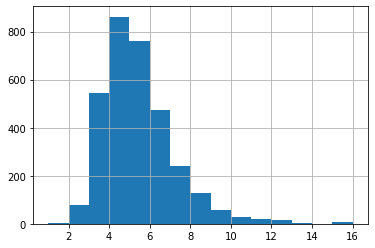

In [171]:
data_temp['key'].value_counts().hist(bins=15)

Распределение количества замеров нормальное, скошенное вправо.

Присутствуют две партии только с одним замером температуры, что свидетельствует о потерянных данных, так как по информации от заказчика десульфирование и соответственно замеры температуры в начале и конце технологического процесса проводятся всегда.

<AxesSubplot:>

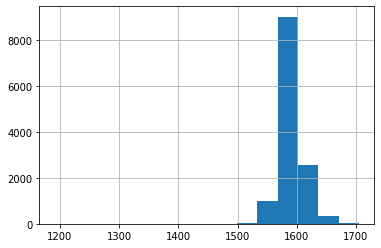

In [172]:
data_temp['Температура'].hist(bins=15)

{'whiskers': [<matplotlib.lines.Line2D at 0x20c90b39c08>,
 'caps': [<matplotlib.lines.Line2D at 0x20c90b3e188>,
 'boxes': [<matplotlib.lines.Line2D at 0x20c90b39588>],
 'medians': [<matplotlib.lines.Line2D at 0x20c90b3ec48>],
 'fliers': [<matplotlib.lines.Line2D at 0x20c90b3eb08>],
 'means': []}

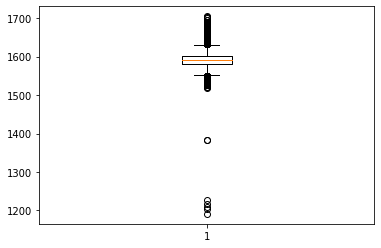

In [173]:
plt.boxplot(data_temp['Температура'].dropna())

Наблюдаются выбросы при замерах температуры. По информации от заказчика температура ниже 1500 свидетельствует либо о нарушении техпроцесса, либо сбое в измерениях, в обоих случаях такие данные рекомендуется не использовать при обучении модели

In [174]:
data_temp.query('Температура < 1500').shape

(7, 3)

### Данные о проволочных материалах (объём)

In [175]:
try:
    data_wire = pd.read_csv('final_steel/data_wire.csv')
except:
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [176]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Аналогично сыпучим материалам среди проволочных материалов также есть редко используемые

In [177]:
data_wire['key'].nunique()

3081

Количество уникальных значений номеров партий соответствует количеству строк, дубликатов нет. Однако оно меньше количества уникальных значений из датасета об электродах

In [178]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


array([[<AxesSubplot:title={'center':'Wire 1'}>,
        <AxesSubplot:title={'center':'Wire 2'}>,
        <AxesSubplot:title={'center':'Wire 3'}>],
       [<AxesSubplot:title={'center':'Wire 4'}>,
        <AxesSubplot:title={'center':'Wire 5'}>,
        <AxesSubplot:title={'center':'Wire 6'}>],
       [<AxesSubplot:title={'center':'Wire 7'}>,
        <AxesSubplot:title={'center':'Wire 8'}>,
        <AxesSubplot:title={'center':'Wire 9'}>]], dtype=object)

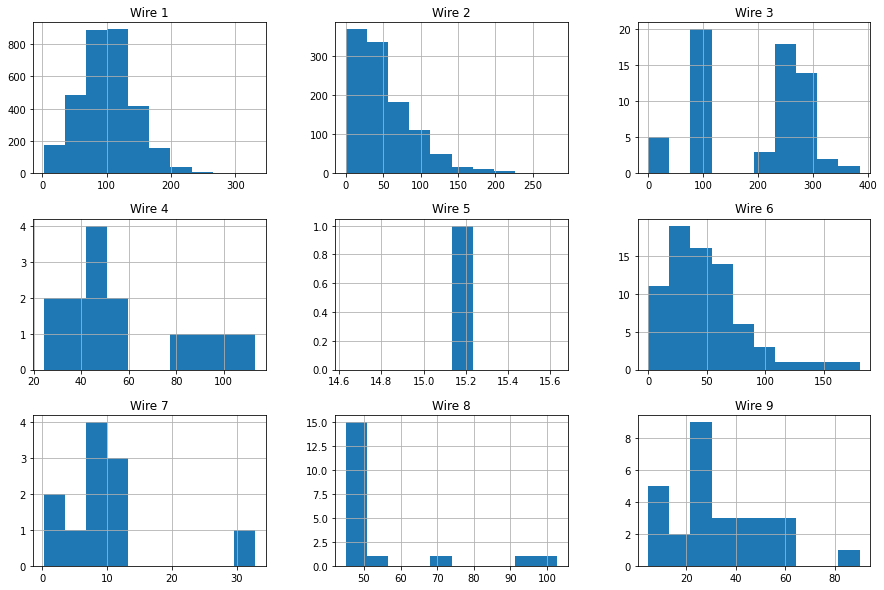

In [179]:
data_wire.drop('key', axis=1).hist(figsize=(15,10))

In [180]:
data_wire.drop('key', axis=1).corr()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
Wire 1,1.000000,-0.030892,0.724370,0.054001,NaN,-0.280807,-0.035072,0.068697,0.010104
Wire 2,-0.030892,1.000000,-0.081852,NaN,NaN,-0.265706,NaN,0.250477,0.011019
Wire 3,0.724370,-0.081852,1.000000,0.069854,NaN,-0.221602,-0.056948,NaN,NaN
Wire 4,0.054001,NaN,0.069854,1.000000,NaN,0.237456,-0.404865,NaN,NaN
Wire 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 6,-0.280807,-0.265706,-0.221602,0.237456,NaN,1.000000,-0.224093,NaN,NaN
Wire 7,-0.035072,NaN,-0.056948,-0.404865,NaN,-0.224093,1.000000,NaN,NaN
Wire 8,0.068697,0.250477,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
Wire 9,0.010104,0.011019,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


<AxesSubplot:>

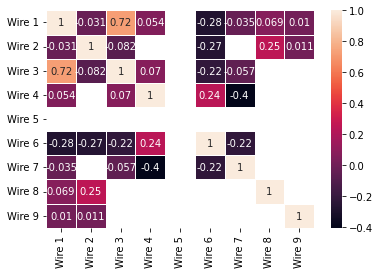

In [181]:
sns.heatmap(data_wire.drop('key', axis=1).corr(), linewidths=.5, annot=True)

In [182]:
get_high_corr_colnames(data_wire.drop('key', axis=1), 0.9)

set()

Высокой корреляции между признаками не наблюдается

### Данные о проволочных материалах (время)

In [183]:
try:
    data_wire_time = pd.read_csv('final_steel/data_wire_time.csv')
except:
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [184]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [185]:
for column in data_wire_time.columns[1:]:
    data_wire_time[column] = pd.to_datetime(data_wire_time[column])

In [186]:
data_wire_time.describe(datetime_is_numeric=True)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055,1079,63,14,1,73,11,19,29
mean,1623.426485,2019-07-03 02:48:18.296235776,2019-07-04 03:36:02.886005504,2019-07-07 13:45:31.634920704,2019-07-08 10:06:53.999999744,2019-08-08 16:01:07,2019-07-04 11:29:18.273972480,2019-08-02 18:36:35.818181632,2019-06-21 00:52:37.894736896,2019-06-28 18:07:46.931034624
min,1.000000,2019-05-03 11:11:41,2019-05-03 13:32:06,2019-05-04 04:47:53,2019-05-07 08:48:23,2019-08-08 16:01:07,2019-05-07 08:37:20,2019-07-23 12:08:44,2019-05-14 00:03:32,2019-05-04 16:09:11
25%,823.000000,2019-06-03 02:59:53.500000,2019-06-03 21:52:38,2019-06-09 14:51:42.500000,2019-07-17 08:17:59,2019-08-08 16:01:07,2019-05-08 13:11:38,2019-07-23 19:31:31,2019-05-14 02:36:03.500000,2019-06-07 20:28:19
50%,1619.000000,2019-06-30 14:38:56,2019-07-02 06:40:13,2019-07-17 21:35:47,2019-07-23 10:44:22.500000,2019-08-08 16:01:07,2019-07-24 03:28:47,2019-08-08 10:43:30,2019-05-14 05:14:25,2019-06-09 10:26:00
75%,2434.000000,2019-08-03 22:58:26,2019-08-04 13:10:39.500000,2019-08-08 10:03:45,2019-07-23 15:27:14.750000128,2019-08-08 16:01:07,2019-08-08 20:28:45,2019-08-08 12:43:10.500000,2019-08-11 11:43:21.500000,2019-08-04 20:48:59
max,3241.000000,2019-09-01 04:16:01,2019-08-31 18:50:15,2019-08-28 02:11:18,2019-08-08 12:03:12,2019-08-08 16:01:07,2019-08-14 00:59:11,2019-08-08 18:27:34,2019-08-11 15:09:29,2019-08-29 03:51:31
std,932.996726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В датасете аналогично присутствуют данные начиная с 3 май 2019 по 1 сентября 2019 что не выходит за пределы рассматриваемого периода.

### Выводы

* Пропуски в данных по сыпучим и проволочным материалам объясняются технологическим процессом и частотой использования тех или иных материалов. Bulk 8 и Wire 5 применялись только единожды
* Пропуски и аномалии в замерах температуры свидетельствуют о нарашении тех процесса или замера и не могут быть использованы при разработке модели
* В датасетах присутствуют данные за 4 месяца, начиная с 3 мая 2019 по 1 сентября 2019
* Между рядом сыпучих материалов присутствует высокая корреляция
* Аномальные значения по газу могут быть объяснены большим количеством итераций

### План решения

1. Исследовательский анализ данных. Анализ основных свойст данных, нахождение в них общих закономерностей, распределений и аномалий.
2. Предобработка данных. Агрегация данных для data_arc и data_temp. Создание дополнительных признаков. Объединение данные в один датасет методом Inner Join. Удаление некорректных значений (отрицательных, пропусков). Деление на обучающую и тестовую выборки. Обработка аномальных значений в обучающей выборке. Подготовка признаков (масштабирование).
3. Разработка модели. Выбор перечня моделей. Выбор диапазонов гиперпараметров. Обучение и поиск оптимальной модели с помощью RandomizedSearchCV
4. Тестирование модели, проверка на адекватность с помощью константной модели, feature importance
5. Составление отчета. 

## Предобработка данных

### Агрегация. Дополнительные признаки. Удаление некорректных значений

#### Данные об электродах

В качестве дополнительных признаков предлагается рассчитать
* суммарную затраченную электроэнергию (кВт*ч)
* среднюю мощность
* суммарное время нагрева
* среднее отношение активной мощности к реактивной.
* количество итераций нагрева

In [187]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Сначала удалим партии с некорректными значениями реактивной мощности

In [188]:
failed_keys = data_arc.loc[data_arc['Реактивная мощность'] <= 0, 'key']
data_arc = data_arc.query('key not in @failed_keys')

In [189]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14872.000000,14872.000000,14872.000000
mean,1615.085732,0.670497,0.500763
std,934.661090,0.408195,0.310897
min,1.000000,0.030002,0.020806
25%,806.000000,0.395297,0.291008
50%,1616.000000,0.555588,0.416280
75%,2429.000000,0.857121,0.637476
max,3241.000000,3.731596,2.676388


Рассчитаем дополнительные признаки

In [190]:
data_arc['Длительность нагрева'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']
data_arc['Длительность нагрева'] = data_arc['Длительность нагрева'].apply(lambda x: x.seconds/3600) # перевод в часы
data_arc['ЭЭ'] = data_arc['Активная мощность'] * data_arc['Длительность нагрева']
data_arc['Отношение Активной к Реактивной'] = data_arc['Активная мощность'] / data_arc['Реактивная мощность']


In [191]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длительность нагрева,ЭЭ,Отношение Активной к Реактивной
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,0.063333,0.061817,1.420582
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.051389,0.041399,1.548395
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.047778,0.035564,1.492292
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,0.101389,0.168241,1.561504
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.041111,0.028480,1.671717


In [192]:
data_arc_agg = data_arc.groupby('key').agg(
    {
        'key': 'count',
        'Активная мощность': 'mean',
        'Реактивная мощность': 'mean',
        'Длительность нагрева': 'sum',
        'Отношение Активной к Реактивной': 'mean',
        'ЭЭ': 'sum'
    }
)
data_arc_agg

,key,Активная мощность,Реактивная мощность,Длительность нагрева,Отношение Активной к Реактивной,ЭЭ
key,,,,,,
1,5,0.975629,0.636648,0.305000,1.538898,0.335501
2,4,0.763150,0.499528,0.225278,1.551834,0.203838
3,5,0.505176,0.319815,0.181944,1.583120,0.123218
4,4,0.802313,0.515074,0.205833,1.563487,0.186295
5,4,0.836793,0.563161,0.241389,1.480428,0.277082
...,...,...,...,...,...,...
3237,5,0.786493,0.565692,0.252500,1.384203,0.216109
3238,3,0.702176,0.560394,0.151667,1.257794,0.120236
3239,8,0.583344,0.388952,0.337778,1.497918,0.234716


In [193]:
data_arc_agg.columns = ['iter_qty', 'p_mean', 'q_mean', 'heating_total', 'pq_coef_mean', 'e_sum']
data_arc_agg.head()

,iter_qty,p_mean,q_mean,heating_total,pq_coef_mean,e_sum
key,,,,,,
1,5,0.975629,0.636648,0.305000,1.538898,0.335501
2,4,0.763150,0.499528,0.225278,1.551834,0.203838
3,5,0.505176,0.319815,0.181944,1.583120,0.123218
4,4,0.802313,0.515074,0.205833,1.563487,0.186295
5,4,0.836793,0.563161,0.241389,1.480428,0.277082


#### Данные измерениях температуры

В качестве дополнительных признаков предлагается
* начальная температура

In [194]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [195]:
data_temp.isna().sum()

key                0
Время замера       0
Температура     2901
dtype: int64

Удалим партии с некорректными или отсутствующими замерами температуры

In [196]:
failed_keys = data_temp.loc[(data_temp['Температура'] < 1500) | pd.isna(data_temp['Температура']), 'key']
data_temp = data_temp.query('key not in @failed_keys')

In [197]:
data_temp_agg = data_temp.groupby('key').agg(
    {
        'key': 'count',
        'Температура': ['first', 'last']
    }
)
data_temp_agg.columns = ['count', 'temp_start', 'temp_final']
data_temp_agg

,count,temp_start,temp_final
key,,,
1,5,1571.0,1613.0
2,6,1581.0,1602.0
3,5,1596.0,1599.0
4,3,1601.0,1625.0
5,2,1576.0,1602.0
...,...,...,...
2495,3,1570.0,1591.0
2496,4,1554.0,1591.0
2497,2,1571.0,1589.0


Удалим также партии с одним замером температуры так как по условию это нарушение техпроцесса либо сбой.

In [198]:
data_temp_agg = data_temp_agg.query('count > 1').drop('count', axis=1)
data_temp_agg

,temp_start,temp_final
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
...,...,...
2495,1570.0,1591.0
2496,1554.0,1591.0
2497,1571.0,1589.0


#### Остальные датасеты

In [200]:
data_bulk.set_index('key', inplace=True)
data_wire.set_index('key', inplace=True)
data_gas.set_index('key', inplace=True)

### Объединение датасетов

По условию мы можем использовать только данные о партиях, информация о которых есть во всех датасетах. Таким образом объединение должно происходить методом inner join

In [201]:
data_full = data_temp_agg.join([data_arc_agg, data_bulk, data_wire, data_gas], how='inner')
data_full

,temp_start,temp_final,iter_qty,p_mean,q_mean,heating_total,pq_coef_mean,e_sum,Bulk 1,Bulk 2,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,5,0.975629,0.636648,0.305000,1.538898,0.335501,NaN,NaN,...,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.749986
2,1581.0,1602.0,4,0.763150,0.499528,0.225278,1.551834,0.203838,NaN,NaN,...,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.555561
3,1596.0,1599.0,5,0.505176,0.319815,0.181944,1.583120,0.123218,NaN,NaN,...,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.554793
4,1601.0,1625.0,4,0.802313,0.515074,0.205833,1.563487,0.186295,NaN,NaN,...,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.841219
5,1576.0,1602.0,4,0.836793,0.563161,0.241389,1.480428,0.277082,NaN,NaN,...,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,4,0.802673,0.590194,0.200833,1.372734,0.173935,NaN,NaN,...,89.150879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.125735
2496,1554.0,1591.0,6,0.700511,0.468364,0.261111,1.491059,0.202186,NaN,NaN,...,114.179527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.412616
2497,1571.0,1589.0,3,0.737460,0.617090,0.158056,1.192036,0.118760,NaN,NaN,...,94.086723,9.04800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.271699


Рассмотрим детальнее получившийся датасет

In [202]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 1 to 2499
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temp_start     2324 non-null   float64
 1   temp_final     2324 non-null   float64
 2   iter_qty       2324 non-null   int64  
 3   p_mean         2324 non-null   float64
 4   q_mean         2324 non-null   float64
 5   heating_total  2324 non-null   float64
 6   pq_coef_mean   2324 non-null   float64
 7   e_sum          2324 non-null   float64
 8   Bulk 1         199 non-null    float64
 9   Bulk 2         13 non-null     float64
 10  Bulk 3         958 non-null    float64
 11  Bulk 4         811 non-null    float64
 12  Bulk 5         53 non-null     float64
 13  Bulk 6         437 non-null    float64
 14  Bulk 7         13 non-null     float64
 15  Bulk 8         1 non-null      float64
 16  Bulk 9         13 non-null     float64
 17  Bulk 10        143 non-null    float64
 18  Bulk 11 

<AxesSubplot:>

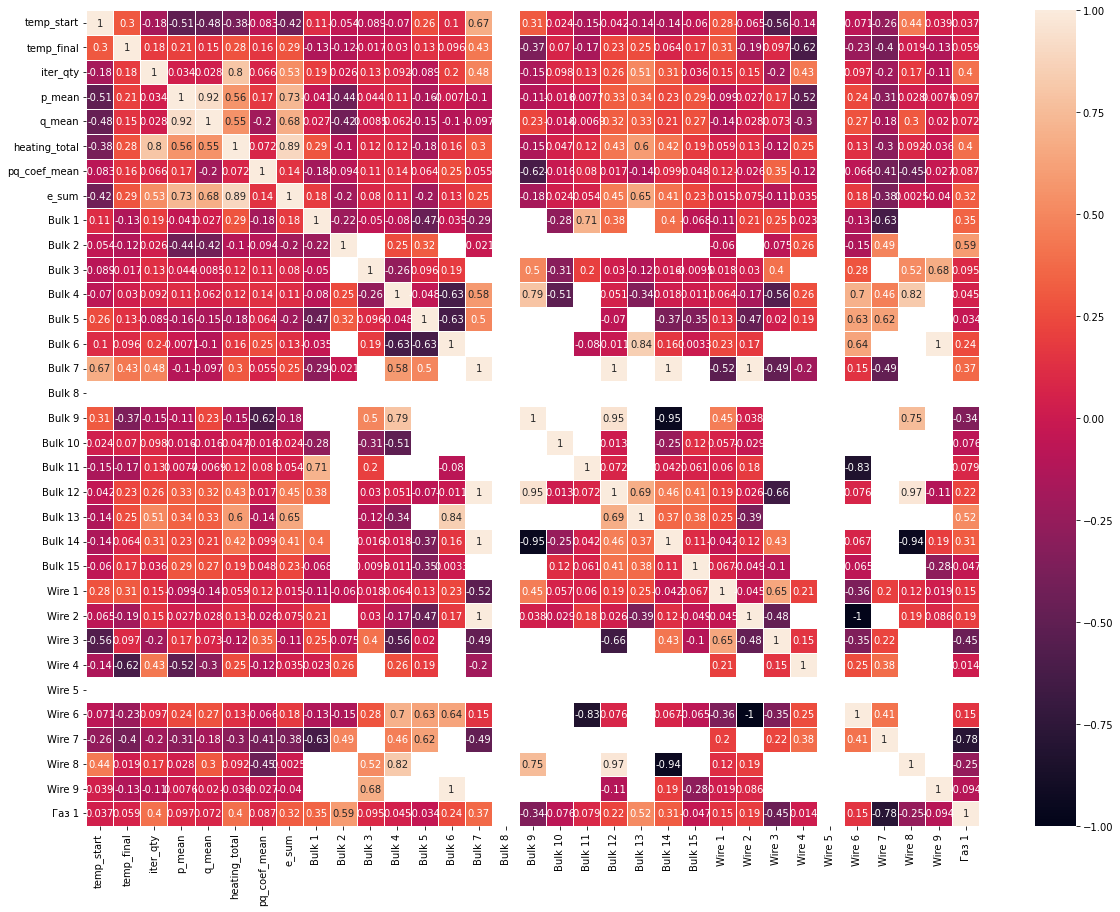

In [203]:
plt.figure(figsize = (20,15))
sns.heatmap(data_full.corr(), linewidths=.5, annot=True)

In [204]:
get_high_corr_colnames(data_full, threshold=.9)

q_mean - p_mean
Bulk 12 - Bulk 7
Bulk 12 - Bulk 9
Bulk 14 - Bulk 7
Bulk 14 - Bulk 9
Wire 2 - Bulk 7
Wire 6 - Wire 2
Wire 8 - Bulk 12
Wire 8 - Bulk 14
Wire 9 - Bulk 6


{'Bulk 12', 'Bulk 14', 'Wire 2', 'Wire 6', 'Wire 8', 'Wire 9', 'q_mean'}

По итогам EDA установлена высокая корреляция между 
* q_mean - p_mean
* Bulk 12 - Bulk 9 и Wire 8
* Bulk 14 - Bulk 7, Bulk 9, Wire 8
* Wire 2 - Bulk 7, Wire 6
* Wire 9 - Bulk 6


Кроме того, некоторые колонки содержат крайне мало значений (менее 1%), например Bulk 8 содержит только одно значения, а Wire 5 не содержит ни одного значения. 

In [205]:
data_full.corr()['temp_final'].sort_values(ascending=False)[:5]

temp_final    1.000000
Bulk 7        0.433107
Wire 1        0.311983
temp_start    0.301882
e_sum         0.285103
Name: temp_final, dtype: float64

In [206]:
data_full.corr()['temp_final'].sort_values(ascending=True)[:5]

Wire 4   -0.621452
Wire 7   -0.399870
Bulk 9   -0.366975
Wire 6   -0.229815
Wire 2   -0.192483
Name: temp_final, dtype: float64

Наибольшая корреляция с целевым признаком наблюдается у признака Wire 4, однако в итоговом объединенном датасете в данной колонке присутствует только 12 значений

Принято решение создать дополнительный датасет очищенный от столбцов с высокой корелляцией и низким количеством значений:

In [207]:
columns_to_drop = [
    'q_mean',
    'Bulk 2',
    'Bulk 7',
    'Bulk 8',
    'Bulk 9',
    'Bulk 13',
    'Wire 4',
    'Wire 5',
    'Wire 6',
    'Wire 7',
    'Wire 8',
    'Wire 9'
]

In [208]:
data_cut = data_full.drop(columns_to_drop, axis=1)
data_cut


,temp_start,temp_final,iter_qty,p_mean,heating_total,pq_coef_mean,e_sum,Bulk 1,Bulk 3,Bulk 4,...,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Газ 1
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,5,0.975629,0.305000,1.538898,0.335501,NaN,NaN,43.0,...,NaN,NaN,NaN,206.0,150.0,154.0,60.059998,NaN,NaN,29.749986
2,1581.0,1602.0,4,0.763150,0.225278,1.551834,0.203838,NaN,NaN,73.0,...,NaN,NaN,NaN,206.0,149.0,154.0,96.052315,NaN,NaN,12.555561
3,1596.0,1599.0,5,0.505176,0.181944,1.583120,0.123218,NaN,NaN,34.0,...,NaN,NaN,NaN,205.0,152.0,153.0,91.160157,NaN,NaN,28.554793
4,1601.0,1625.0,4,0.802313,0.205833,1.563487,0.186295,NaN,NaN,81.0,...,NaN,NaN,NaN,207.0,153.0,154.0,89.063515,NaN,NaN,18.841219
5,1576.0,1602.0,4,0.836793,0.241389,1.480428,0.277082,NaN,NaN,78.0,...,NaN,NaN,NaN,203.0,151.0,152.0,89.238236,9.11456,NaN,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,4,0.802673,0.200833,1.372734,0.173935,NaN,21.0,NaN,...,NaN,90.0,NaN,256.0,129.0,223.0,89.150879,NaN,NaN,7.125735
2496,1554.0,1591.0,6,0.700511,0.261111,1.491059,0.202186,NaN,NaN,63.0,...,NaN,122.0,NaN,256.0,129.0,226.0,114.179527,NaN,NaN,9.412616
2497,1571.0,1589.0,3,0.737460,0.158056,1.192036,0.118760,NaN,NaN,85.0,...,NaN,NaN,NaN,230.0,124.0,226.0,94.086723,9.04800,NaN,6.271699


In [209]:
data_full.fillna(0, inplace=True)
data_cut.fillna(0, inplace=True)

### Деление на выборки

Принимая во внимание малое количество данных, выборка будет разделена на обучующую и тестовую, для валидации модели будет использована кроссвалидация.

In [210]:
features_full = data_full.drop('temp_final', axis=1)
target_full = data_full['temp_final']

In [211]:
features_full_train, features_full_test, target_full_train, target_full_test = train_test_split(
    features_full, target_full, test_size=.25, random_state=RANDOM_STATE
)

In [212]:
print('Полная выборка: ', features_full_train.shape, target_full_train.shape, features_full_test.shape, target_full_test.shape)

Полная выборка:  (1743, 32) (1743,) (581, 32) (581,)


In [213]:
features_cut = data_cut.drop('temp_final', axis=1)
target_cut = data_cut['temp_final']

In [214]:
features_cut_train, features_cut_test, target_cut_train, target_cut_test = train_test_split(
    features_cut, target_cut, test_size=.25, random_state=RANDOM_STATE
)

In [215]:
print('Урезанная выборка: ', features_cut_train.shape, target_cut_train.shape, features_cut_test.shape, target_cut_test.shape)

Урезанная выборка:  (1743, 20) (1743,) (581, 20) (581,)


### Масштабирование признаков

In [216]:
scaler = StandardScaler()
scaler.fit(features_full_train)
features_full_train = scaler.transform(features_full_train)
features_full_test = scaler.transform(features_full_test)

In [217]:
scaler = StandardScaler()
scaler.fit(features_cut_train)
features_cut_train = scaler.transform(features_cut_train)
features_cut_test = scaler.transform(features_cut_test)

## Обучение

### Подбор гиперпараметров

Создадим экземпляры модели

In [218]:
linear = LinearRegression()

In [219]:
random_forest = RandomForestRegressor(
    random_state=RANDOM_STATE,
    criterion="absolute_error"
)

In [220]:
lgbm = LGBMRegressor(random_state=RANDOM_STATE)

In [221]:
catboost = CatBoostRegressor(
    random_state=RANDOM_STATE,
    verbose=False,
    loss_function='MAE',
)

Настроим диапазоны гиперпараметров для RandomizedSearchCV

In [222]:
param_distibution_rf = [{
    'n_estimators': range(10, 101, 10),
    'max_depth': range(1, 11),
}]

In [223]:
param_distibution_lgbm = [{
    'learning_rate': np.arange(0.1, 1, 0.1),
    'max_depth': range(1, 6),
}]

In [224]:
param_distibution_catboost = [{
    'learning_rate': np.arange(0.1, 1, 0.1),
    'max_depth': range(1, 6),
}]

Настроим параметры кросс-валидации

In [225]:
cv = 5
jobs = -1
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [226]:
RF = RandomizedSearchCV(
    estimator=random_forest,
    param_distributions=param_distibution_rf,
    scoring=scorer,
    cv=cv,
    n_jobs=jobs,
    random_state=RANDOM_STATE
)

In [227]:
LGBM = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_distibution_lgbm,
    scoring=scorer,
    cv=cv,
    n_jobs=jobs,
    random_state=RANDOM_STATE
)

In [228]:
CB = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=param_distibution_catboost,
    scoring=scorer,
    cv=cv,
    #n_jobs=jobs,
    random_state=RANDOM_STATE,
    error_score='raise'
)

In [229]:
regressors = [RF, LGBM, CB]
regressors_dict = {
    0: 'RandomForestRegressor',
    1: 'LGBMRegressor',
    2: 'CatBoostRegressor'
}

### Обучение моделей

In [230]:
linear_mae_cv = abs( cross_val_score(linear, features_cut_train, target_cut_train, cv=5, scoring=scorer) ).mean()
linear_mae_cv

6.094933596588316

In [231]:
linear.fit(features_cut_train, target_cut_train)
predictions = linear.predict(features_cut_test)
linear_mae_test = mean_absolute_error(target_cut_test, predictions)
linear_mae_test

6.347600398437737

In [232]:
best_mae = 1000
best_regressor = ''
best_regressor_idx = 0

for i, regressor in enumerate(regressors):
    print('\nModel: %s' % regressors_dict[i])
    regressor.fit(features_full_train, target_full_train)
    mae_cv = abs(regressor.best_score_)
    print('Best params are : %s' % regressor.best_params_)
    print('Best CV MAE score: %.3f' % mae_cv)

    if mae_cv < best_mae:
        best_mae = mae_cv
        best_regressor = regressor
        best_regressor_idx = i
print('\nModel with best CV MAE score: %s' % regressors_dict[best_regressor_idx])
print('CV MAE score for best model: %.3f ' % best_mae) 


Model: RandomForestRegressor
Best params are : {'n_estimators': 100, 'max_depth': 10}
Best CV MAE score: 6.154

Model: LGBMRegressor
Best params are : {'max_depth': 4, 'learning_rate': 0.1}
Best CV MAE score: 5.916

Model: CatBoostRegressor
Best params are : {'max_depth': 4, 'learning_rate': 0.1}
Best CV MAE score: 5.880

Model with best CV MAE score: CatBoostRegressor
CV MAE score for best model: 5.880 


## Тестирование

Проверим на тестовой выборке модель показавшую лучшую метрику на кросс-валидации

In [233]:
predictions = best_regressor.predict(features_full_test)
mae_test = mean_absolute_error(target_full_test, predictions)
print('Test MAE score of best regressor: %.3f ' % mae_test)

Test MAE score of best regressor: 5.956 


Достигнута целевая метрика

## Важность признаков

<BarContainer object of 32 artists>

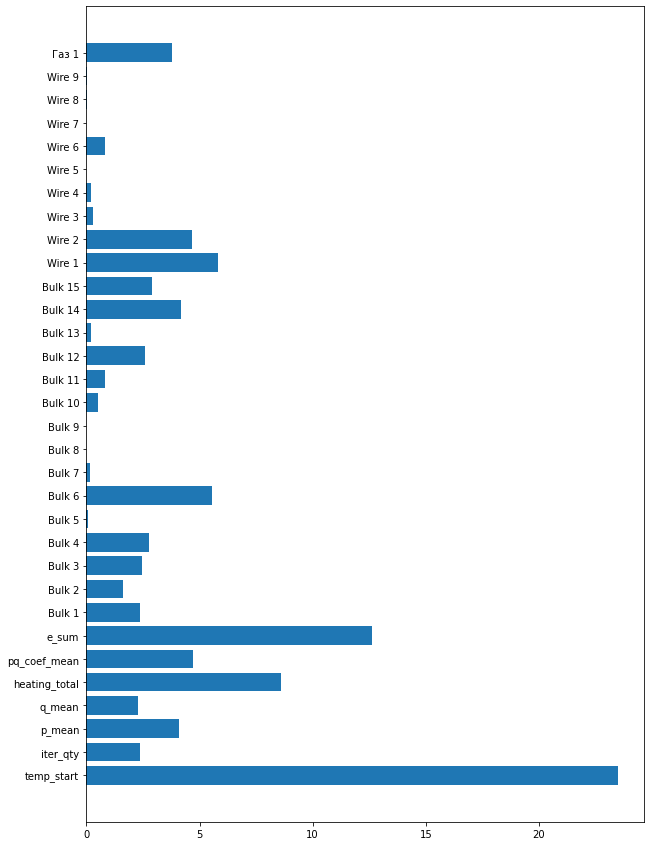

In [234]:
plt.figure(figsize=(10,15))
plt.barh(
    features_full.columns,
    best_regressor.best_estimator_.feature_importances_,
)

Наибольшее влияние на целевой признак оказывают начальная температура сплава, суммарная электроэнергия, и суммарная длительность нагрева

## Проверка на адекватность

Проверим модель на адекватность с помощью констрантной модели

In [235]:
DR_model = DummyRegressor(strategy='mean')
DR_model.fit(features_full_train, target_full_train)
DR_predictions = DR_model.predict(features_full_test)
DR_score_test = mean_absolute_error(target_full_test, DR_predictions)
DR_score_test

8.23479608130085

МАЕ константной модели существенно выше метрики простой логистической регрессии

## Выводы

* В рамках предобработки данных было произведено удаление данных о партиях с ошибочными значениями по реактивной мощности и измерениям температуры, агрегация данные об электродах и измерений температуры, объединение датасетов в единый, а также масштабирование признаков
* Наибольшую точность показала модель CatBoostRegressor с параметрами: 'max_depth': 4, 'learning_rate': 0.1
* Полученная метрика МАЕ = 5.956, что ниже целевой
* Адекватность модели проверена с помощью константной модели
* Наибольшее влияние на целевой признак оказывают начальная температура сплава, суммарная электроэнергия, и суммарная длительность нагрева
* Среди сыпучих материалов и проволоки наибольшее влияние на целевой признак оказывают Bulk 6, Wire 1 и Wire 2

## Отчет о проекте

**Цель проекта**

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали. Задача - предсказать конечную измеренную температуру, то есть самое последнее наблюдение по ключу. Модель будет использоваться для моделирования различных сценариев технологического процесса. Конечные пользователи - технологи заказчика на производстве.

**Описание технологического процесса**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»)

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).


**Дополнительные условия**

* Целевая метрика оптимальная и согласованная с заказчиком MAE <= 6. 
* Также по информации от заказчика минимальная температура при десульфировании 1500 градусов. Температура ниже свидетельствует либо о нарушении техпроцесса, либо сбое в измерениях, в обоих случаях такие данные рекомендуется не использовать при обучении модели.

**Ход проекта / Ключевые этапы**

1. Выполнен исследовательский анализ данных. Анализ основных свойст данных, нахождение в них общих закономерностей, распределений и аномалий. В рамках данного этапа 
    * были обнаружены аномальные и некорректные (отрицательные) значения по признаку Реактивная мощность.
    * отмечаются, что по некоторым ключам (партиям) данные присутствуют не во всех датасетам
    * определен период сбора данных: 4 месяца, с 3 мая по 1 сентября 2019
    * определено максимальное число итераций нагрева 16. В среднем нагревают 4.6 раза.
    * при этом в датасете с результатами замеров температуры были обнаружены партии с единичными замерами температуры, что по информации от заказчика является свидетельством нарушения тех процесса
    * отмечается, что виды сыпучих материалов и проволики разнятся по частоте использования, существуют достаточно редкие, например Bulk 8 и Wire 5 использовались только один раз
    * при этом наблюдается высокая корреляция между некоторыми видами сыпучих материалов и проволоки

<AxesSubplot:>

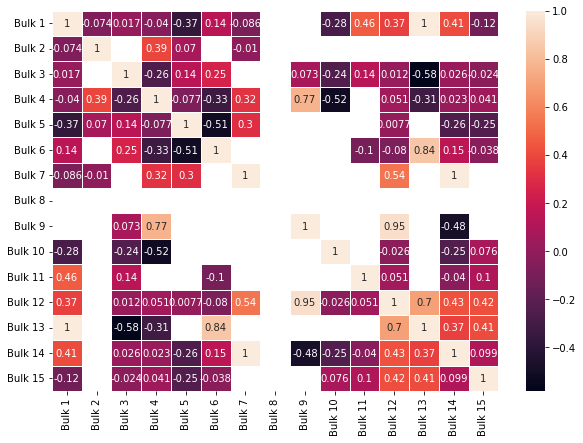

In [236]:
plt.figure(figsize = (10,7))
sns.heatmap(data_bulk.corr(), linewidths=.5, annot=True)

2. Предобработка данных. В рамках данного этапа
    * удаление некорректных значений (отрицательных, пропусков)
    * была выполнена агрегация данных для data_arc и data_temp и создание дополнительных признаков:
        - суммарная затраченную электроэнергию (кВт*ч)
        - средняя мощность
        - суммарное время нагрева
        - среднее отношение активной мощности к реактивной.
        - количество итераций нагрева
    * объединение данных в один датасет методом Inner Join. В итоговый датасет попали все имеющиеся в распоряжении признаки 
    * деление на обучающую и тестовую выборки в соотношении 1:3
    * подготовка признаков (масштабирование)
    * анализ корреляции признаков объединенного датасета

In [237]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 1 to 2499
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temp_start     2324 non-null   float64
 1   temp_final     2324 non-null   float64
 2   iter_qty       2324 non-null   int64  
 3   p_mean         2324 non-null   float64
 4   q_mean         2324 non-null   float64
 5   heating_total  2324 non-null   float64
 6   pq_coef_mean   2324 non-null   float64
 7   e_sum          2324 non-null   float64
 8   Bulk 1         2324 non-null   float64
 9   Bulk 2         2324 non-null   float64
 10  Bulk 3         2324 non-null   float64
 11  Bulk 4         2324 non-null   float64
 12  Bulk 5         2324 non-null   float64
 13  Bulk 6         2324 non-null   float64
 14  Bulk 7         2324 non-null   float64
 15  Bulk 8         2324 non-null   float64
 16  Bulk 9         2324 non-null   float64
 17  Bulk 10        2324 non-null   float64
 18  Bulk 11 

3. Разработка модели. 
    В рамках данного этапа были выбраны модели LinearRegression, RandomForestRegressor, LGBMRegressor, CatboostRegressor, чтобы была возможность сравнить линейные модели, модели на основе деревьев и модели с градиентным бустингом. Подбор гиперпараметров осуществлялся с помощью RandomizedSearchCV. Обучение и поиск оптимальной модели с помощью кросс-валидации с числом блоков 5.
    
    Наибольшую точность показала модель CatBoostRegressor с параметрами: `max_depth`: 4, `learning_rate`: 0.1, `random_state`: 80822 и loss_funtion = `mae`. Полученная метрика МАЕ = 5.880

In [238]:
pd.DataFrame(
    index=['linear', 'random forest', 'LGBM', 'Catboost'],
    data={'MAE_CV': [abs(linear_mae_cv), abs(RF.best_score_), abs(LGBM.best_score_), abs(CB.best_score_)]}
)

,MAE_CV
linear,6.094934
random forest,6.153714
LGBM,5.916481
Catboost,5.880118


4. Тестирование лучшей модели выполнено на тестовой выборке, полученная метрика МАЕ = 5.956, что ниже целевой.
    Также была выполнена проверка на адекватность с помощью константной модели со стратегией `mean`.
    Кроме того, в рамках анализа важности признаков определено, что наибольшее влияние на целевой признак оказывают начальная температура сплава, суммарная электроэнергия, и суммарная длительность нагрева. Среди сыпучих материалов и проволоки наибольшее влияние на целевой признак оказывают Bulk 6, Wire 1 и Wire 2

<BarContainer object of 32 artists>

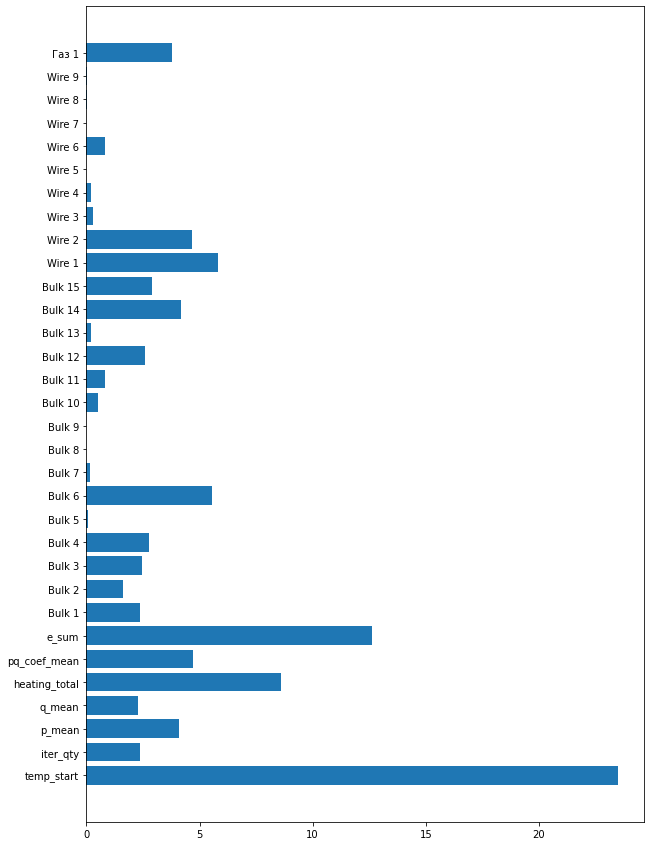

In [239]:
plt.figure(figsize=(10,15))
plt.barh(
    features_full.columns,
    best_regressor.best_estimator_.feature_importances_,
)

**Сложности**

Проект в целом выполнен в соответствии с первоначальным планом, однако принимая во внимание что модель должна работать на реальных данных из предобработки данных была исключена обработка выбросов, чтобы избежать переобучения модели на тренировочной выборке.

Так как с помощью подбора гиперпараметров не удавалось достичь целевой метрики была применено масштабирование признаков с помощью StandardScaler, что позволило снизить MAE ниже 6.